<a href="https://colab.research.google.com/github/LejoFlores/geos511-land-atmosphere-interaction/blob/main/soil_moisture_model/SimpleSoilMoistureModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Profile-Integrated Soil Moisture Model

### 1. Import Required Libraries, Define Constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Meteorological forcing file and parameters
met_forcing_file = 'KONZ_met_forcing_2019-2020.csv'
phi = 39.09 # Latitude at Konza Prairie Biological Station

### Output File Name
model_outp_file = 'konza_base_case.csv'

### Time step
dt = 1

### Soil parameters
Zr = 300.00 #
n = 0.45 # Loam
theta_r = 0.05 # cm^3/cm^3, loam
theta_s = 0.45 # cm^3/cm^3, loam
Ks = 120.5 # mm/day, loam
fmax = 182.88 # mm/day, loam
eta = 4
lambda_f = 2

# Vegetation Parameters
Kc = 0.8 # Grasses
S_star = 0.15
S_wp = 0.05
z_a = 2.0 # m - Measurement height
h_c = 1.0 # m - Canopy height
d = 0.75*h_c # m - Zero plane displacement
epsilon_d = 0.10*h_c # m - Roughness length
alpha = 0.45 # albedo

S0 = 0.3

### 2. Define Model Functions for Fluxes

Calculation of Extraterrestrial Radiation is from this [FAO website:](https://www.fao.org/4/x0490e/x0490e07.htm#TopOfPage)

In [2]:
def theta2sat(theta, theta_r, theta_s):
  S_e = (theta - theta_r)/(theta_s - theta_r)
  return S_e

def sat2theta(S_e, theta_r, theta_s):
  theta = theta_r + S_e*(theta_s - theta_r)
  return theta

def drainage(S_e, Ks, eta):
  return Ks*S_e**eta

def infiltration(S_e, fmax, lambda_f, P):
  f = fmax*(1 - S_e**lambda_f)
  return np.minimum(f, P)

### 2a. Hargreaves ET Functions

In [3]:
def ExtraterrestrialRadiation(phi,J):
  # Computes daily extraterrestrial radiation based on latitude, day of year
  phi = phi*np.pi/180.0
  d_r = 1.00011 + 0.034221*np.cos(2*np.pi*J/365)
  delta = 0.409*np.sin(2*np.pi/365*J - 1.39)
  omega_s = np.arccos(-np.tan(phi)*np.tan(delta))
  Ra = (24.0*60.0)/np.pi*0.0820*d_r*(omega_s*np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta)*np.sin(omega_s))
  Ra = 0.408*Ra # Convert units from MJ/m^2/day to mm/day
  return Ra

def ET_hargreaves(T_avg, T_max, T_min, Kc, phi, J, S_star, S_wp, S_e):
  Ra = ExtraterrestrialRadiation(phi,J)
  ET0 = 0.0023*(T_avg + 17.8)*np.sqrt(np.abs(T_max - T_min))*Ra
  PET = Kc*ET0

  if (S_e > S_star):
    AET = PET
  elif (S_e < S_wp):
    AET = 0.0
  else:
    AET = PET*(S_e - S_wp)/(S_star - S_wp)
  return AET


### 2b. Penman Equation Functions

In [4]:
# Slope of the Clausius-Clapeyron Relationship
def Delta(Ta):
  delta = 4098.0*(0.611*np.exp(17.27*Ta)/(Ta + 237.3))/(Ta + 237.3)**2
  return delta

# The psychrometric constant
def Gamma(P0):
  Cp = 1.013E-3 # MJ/kg/°C – Specific heat at constant pressure
  lambda_v = 2.45 # MJ/kg – latent heat of vaporization
  epsilon = 0.622
  gamma = Cp*P0/(lambda_v*epsilon)
  return gamma

# Aerodynamic resistance
def ra(za, zd, d, u):
  kappa = 0.4
  ra = np.log((za-d)/zd)**2/(kappa**2*u)
  return ra

# Vapor pressure deficit
def VPD(RH,Ta):
  es = 0.611*np.exp(17.27*Ta/(237.3+Ta))*RH/100
  vpd = (1-RH)*es
  return vpd

# Calculate evapotranspiration
def ET_Penman(Ta,P0,u,za,zd,d,RH,Rn,S_e,S_star,S_wp):
  Cp = 1.013E-3 # MJ/kg/°C – Specific heat at constant pressure
  lambda_v = 2.45E6 # J/kg – latent heat of vaporization
  rho_a = 1.225 # kg/m^3 – air density
  rho_w = 1000.0 # kg/m^3 – water density
  epsilon = 0.622
  delta = Delta(Ta)
  gamma = Gamma(P0)
  r_a = ra(za, zd, d, u)
  vpd = VPD(RH,Ta)

  PET = (1/lambda_v)*(delta/(delta + gamma))*Rn + (epsilon*rho_a)/(P0*r_a)*(gamma/(gamma + delta))*vpd

  # PET is in mass flux units (kg/m^2/s). Convert to mm/day
  PET = PET / rho_w * 1000 * 24 * 60 * 60

  # Restrict ET based on soil moisture
  if (S_e > S_star):
    AET = PET
  elif (S_e < S_wp):
    AET = 0.0
  else:
    AET = PET*(S_e - S_wp)/(S_star - S_wp)
  return AET


### 3. Load Meteorological Data

In [5]:
df_forcing = pd.read_csv(met_forcing_file)

P_neon = df_forcing['prcp']
T_mean_neon = df_forcing['tmean']
T_min_neon = df_forcing['tmin']
T_max_neon = df_forcing['tmax']
J_neon = pd.to_datetime(df_forcing['date']).dt.dayofyear

P0_neon = df_forcing['airp']
RH_neon = df_forcing['relh'] / 100.0 # NEON RH is in percent – convert to decimal fraction
u_neon = df_forcing['wspd']
Rn_neon = df_forcing['srad'] * (1 - alpha) # Converting solar to net solar - neglecting longwave

dates_neon = pd.to_datetime(df_forcing['date'])

Nt = P_neon.size

### 4. Initialize Containers to Store Model Outputs

In [6]:
S_h = np.zeros(Nt)
S_pm = np.zeros(Nt)
ET_h = np.zeros(Nt)
ET_pm = np.zeros(Nt)
f_h = np.zeros(Nt)
f_pm = np.zeros(Nt)
L_h = np.zeros(Nt)
L_pm = np.zeros(Nt)

### 5. Run the Model

In [7]:
for i in np.arange(Nt):

  P = P_neon[i]
  T_avg = T_mean_neon[i]
  T_max = T_max_neon[i]
  T_min = T_min_neon[i]
  J = J_neon[i]

  if i==0:
    Sim1_h = S0
    Sim1_pm = S0
  else:
    Sim1_h = S_h[i-1]
    Sim1_pm = S_pm[i-1]

  L_h[i] = drainage(Sim1_h, Ks, eta)
  f_h[i] = infiltration(Sim1_h, fmax, lambda_f, P)
  ET_h[i] = ET_hargreaves(T_avg, T_max, T_min, Kc, phi, J, S_star, S_wp, Sim1_h)
  S_h[i] = np.clip(Sim1_h + dt/(n*Zr)*(f_h[i] - L_h[i] - ET_h[i]), 0.0, 1.0)

  L_pm[i] = drainage(Sim1_pm, Ks, eta)
  f_pm[i] = infiltration(Sim1_pm, fmax, lambda_f, P)
  ET_pm[i] = ET_Penman(T_avg, P0_neon[i], u_neon[i], z_a, epsilon_d, d, RH_neon[i], Rn_neon[i], Sim1_pm, S_star, S_wp)
  S_pm[i] = np.clip(Sim1_pm + dt/(n*Zr)*(f_pm[i] - L_pm[i] - ET_pm[i]), 0.0, 1.0)


### 6. Save the Outputs

In [8]:
model_data = {
    'date': dates_neon,
    's_e_h': S_h,
    'soimoi_h': sat2theta(S_h, theta_r, theta_s),
    'qinf_h': f_h,
    'qrch_h': L_h,
    'ET_h': ET_h,
    's_e_pm': S_pm,
    'soimoi_pm': sat2theta(S_pm, theta_r, theta_s),
    'qinf_pm': f_pm,
    'qrch_pm': L_pm,
    'ET_pm': ET_pm,
}

df_model_output = pd.DataFrame(model_data)
df_model_output.to_csv(model_outp_file)

### 7. Plot Model Output

<ipython-input-10-bd0f4ae4ab1e>:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2].legend()


Text(0, 0.5, 'Mean Temperature [°C]')

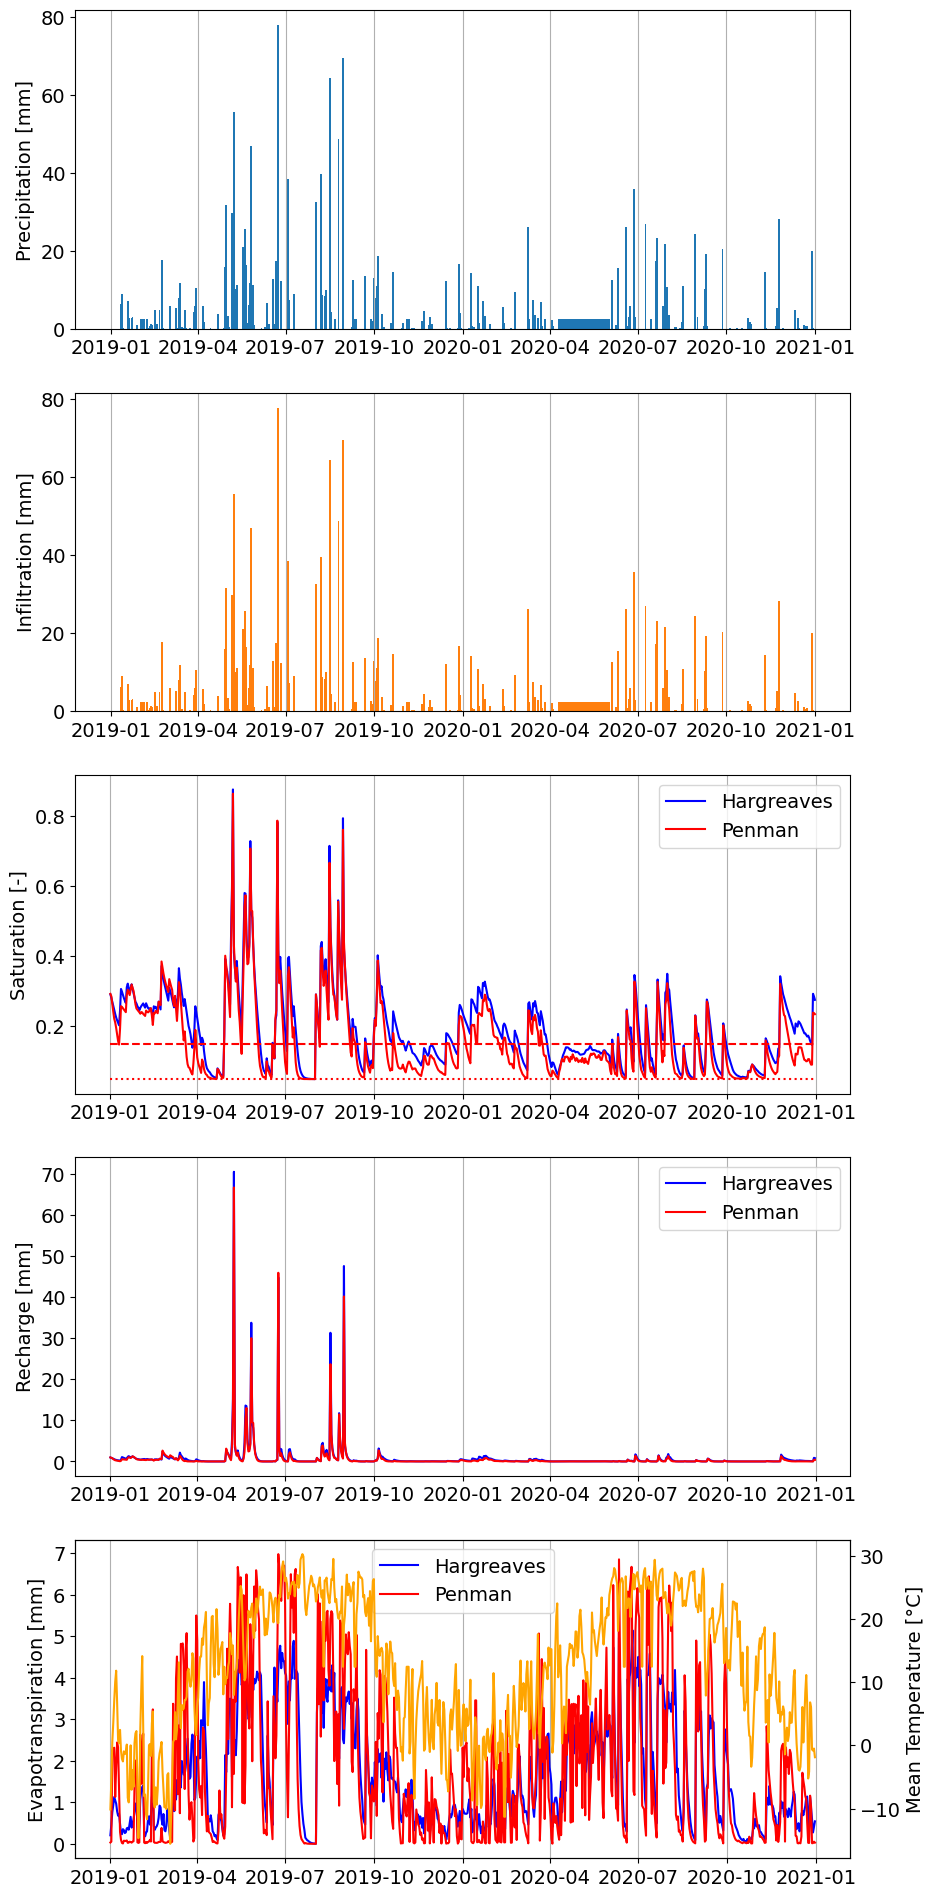

In [10]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(5,figsize=(10,24))
ax[0].bar(dates_neon,P_neon,width=2)
ax[0].grid(axis='x')
ax[0].set_ylabel('Precipitation [mm]')

ax[1].bar(dates_neon,f_h,width=2,label='Hargreaves')
ax[1].bar(dates_neon,f_pm,width=2,label='Penman')
ax[2].legend()
ax[1].grid(axis='x')
ax[1].set_ylabel('Infiltration [mm]')

ax[2].plot(dates_neon,S_h,'b-',label='Hargreaves')
ax[2].plot(dates_neon,S_pm,'r-',label='Penman')
ax[2].legend()
ax[2].hlines(S_star,dates_neon.min(),dates_neon.max(),colors='red',linestyle='dashed')
ax[2].hlines(S_wp,dates_neon.min(),dates_neon.max(),colors='red',linestyle='dotted')
ax[2].grid(axis='x')
ax[2].set_ylabel('Saturation [-]')

ax[3].plot(dates_neon,L_h,'b-',label='Hargreaves')
ax[3].plot(dates_neon,L_pm,'r-',label='Penman')
ax[3].legend()
ax[3].grid(axis='x')
ax[3].set_ylabel('Recharge [mm]')

ax[4].plot(dates_neon,ET_h,'b-',label='Hargreaves')
ax[4].plot(dates_neon,ET_pm,'r-',label='Penman')
ax[4].legend()
ax[4].grid(axis='x')
ax[4].set_ylabel('Evapotranspiration [mm]')

ax4 = ax[4].twinx()
ax4.plot(dates_neon,T_mean_neon,color='orange')
ax4.set_ylabel('Mean Temperature [°C]')

